# IRAM Data Example

Trey V. Wenger (c) December 2024

Here we test `bayes_cn_hfs` on some real IRAM 30-m data and demonstrate a general procedure for determining the carbon isotopic ratio from observations of CN and 13CN.

In [1]:
# General imports   
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+6.ge3576a9.dirty


## Load the data

12CN-1/2 650
12CN-3/2 551
13CN-1/2 550
13CN-3/2 550


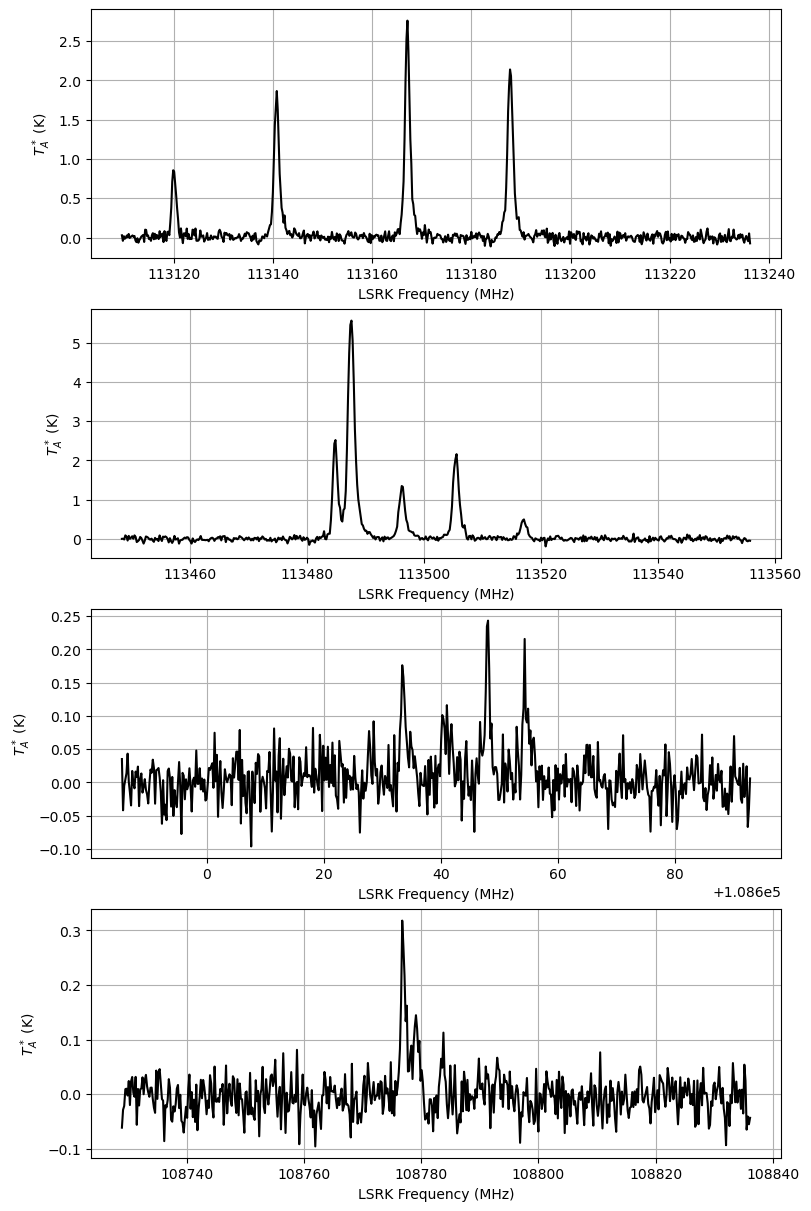

In [2]:
from bayes_spec import SpecData
import pickle

with open("iram_data.pkl", "rb") as f:
    iram_data = pickle.load(f)

labels = ["12CN-1/2", "12CN-3/2", "13CN-1/2", "13CN-3/2"]
data = {
    label: SpecData(
        iram_data[f"frequency_{label}"][500:-500],
        iram_data[f"spectrum_{label}"][500:-500],
        iram_data[f"rms_{label}"],
        xlabel=r"LSRK Frequency (MHz)",
        ylabel=r"$T_A^*$ (K)",
    )
    for label in labels
}
for label, dataset in data.items():
    print(label, len(dataset.spectral))
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

# subset of 12CN data
data_12CN = {
    label: data[label]
    for label in labels if "12CN" in label
}

# Plot the data
fig, axes = plt.subplots(4, layout="constrained", figsize=(8, 12))
for i, label in enumerate(labels):
    axes[i].plot(data[label].spectral, data[label].brightness, 'k-')
    axes[i].set_xlabel(data[label].xlabel)
    axes[i].set_ylabel(data[label].ylabel)

## Inspecting the CN data

We don't assume LTE, but we fix the kinetic temperature.

In [16]:
from bayes_cn_hfs.cn_model import CNModel
from bayes_cn_hfs import get_molecule_data

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)

n_clouds = 1
baseline_degree = 0
model = CNModel(
    data_12CN,
    molecule="CN", # molecule name
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0 = [14.0, 1.0], # mean and width of log10 ground state column density prior (cm-2)
    prior_log10_Tkin = None, # ignored for this fixed kinetic temperature model
    prior_velocity = [10.0, 5.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s)
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = None, # ignored for non-CTEX model
    assume_CTEX = False, # do not assume CTEX
    prior_log10_inv_boltz_factor = 5.0, # width of Boltzmann factor prior distribution
    fix_log10_Tkin = 1.5, # fix kinetic temperature 
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Transition 113144.19 is constraining upper state 0 from lower state 0
Transition 113191.325 is constraining upper state 2 from lower state 0
Transition 113490.985 is constraining upper state 1 from lower state 0
Transition 113508.934 is constraining upper state 3 from lower state 0
Transition 113520.4215 is constraining upper state 4 from lower state 0
Transition 113123.3687 is constraining lower state 1 from upper state 0
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]


Sampling: [12CN-1/2, 12CN-3/2, baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N0_norm, log10_inv_boltz_factor_free, velocity_norm]


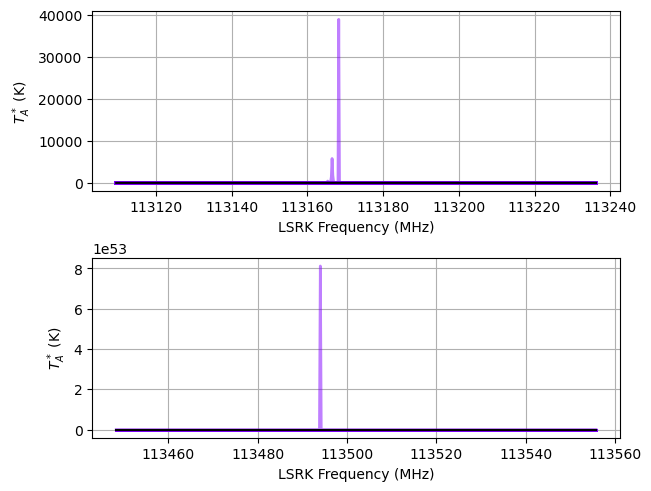

In [17]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [18]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.05, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 5300
Interrupted at 5,299 [5%]: Average Loss = 4.2039e+05


Output()

Runtime: 0.88 minutes


In [19]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "transition_free", "state_l", "state_u"]))
]
pm.summary(model.trace.posterior, var_names=var_names + ["Tex", "tau"] + model.hyper_deterministics + model.baseline_freeRVs)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
velocity[0],9.134,0.007,9.122,9.148,0.000,0.000,936.0,931.0,NaN
fwhm_thermal[0],0.236,0.000,0.236,0.236,0.000,0.000,1000.0,1000.0,NaN
fwhm_nonthermal[0],1.858,0.021,1.817,1.896,0.001,0.000,968.0,1017.0,NaN
fwhm[0],1.873,0.021,1.832,1.910,0.001,0.000,968.0,1017.0,NaN
log10_N0[0],14.278,0.003,14.272,14.284,0.000,0.000,1105.0,888.0,NaN
log10_N[0],14.822,0.003,14.816,14.829,0.000,0.000,1068.0,888.0,NaN
tau_total[0],14.172,0.124,13.957,14.404,0.004,0.003,988.0,875.0,NaN
"Tex[113123.3687, 0]",6.877,0.056,6.771,6.975,0.002,0.001,1048.0,790.0,NaN
"Tex[113144.19, 0]",6.048,0.035,5.979,6.108,0.001,0.001,932.0,975.0,NaN
"Tex[113170.535, 0]",7.658,0.099,7.472,7.842,0.003,0.002,900.0,974.0,NaN


Sampling: [12CN-1/2, 12CN-3/2]


Output()

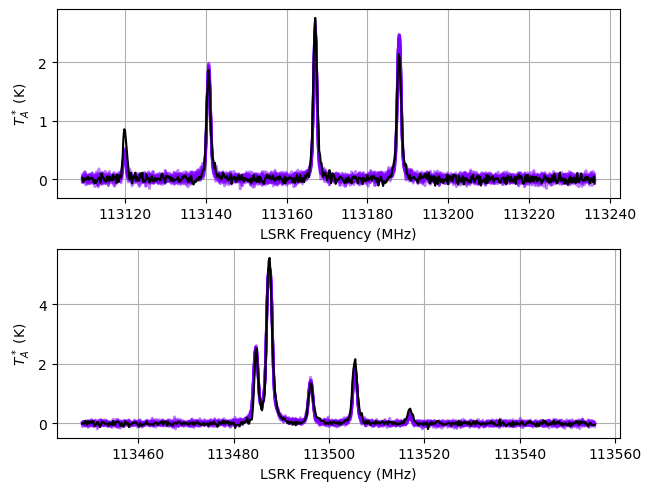

In [20]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Number of cloud components

In [4]:
from bayes_spec import Optimize
from bayes_cn_hfs.cn_model import CNModel
from bayes_cn_hfs import get_molecule_data

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)

max_n_clouds = 6
baseline_degree = 0
opt = Optimize(
    CNModel,
    data_12CN,
    molecule="CN", # molecule name
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    max_n_clouds=max_n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
opt.add_priors(
    prior_log10_N0 = [13.5, 0.5], # mean and width of log10 ground state column density prior (cm-2)
    prior_log10_Tkin = None, # ignored for this fixed kinetic temperature model
    prior_velocity = [10.0, 5.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s)
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = None, # ignored for non-CTEX model
    assume_CTEX = False, # do not assume CTEX
    prior_log10_inv_boltz_factor = 5.0, # width of Boltzmann factor prior distribution
    fix_log10_Tkin = 1.5, # fix kinetic temperature 
    ordered = False, # do not assume optically-thin
)
opt.add_likelihood()

Transition 113144.19 is constraining upper state 2 from lower state 0
Transition 113191.325 is constraining upper state 1 from lower state 0
Transition 113490.985 is constraining upper state 4 from lower state 0
Transition 113508.934 is constraining upper state 3 from lower state 0
Transition 113520.4215 is constraining upper state 0 from lower state 0
Transition 113123.3687 is constraining lower state 1 from upper state 2
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]
Transition 113144.19 is constraining upper state 2 from lower state 0
Transition 113191.325 is constraining upper state 1 from lower state 0
Transition 113490.985 is constraining upper state 4 from lower state 0
Transition 113508.934 is constraining upper state 3 from lower state 0
Transition 113520.4215 is constraining upper state 0 from lower state 0
Transition 1

Sampling: [12CN-1/2, 12CN-3/2, baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N0_norm, log10_inv_boltz_factor_free, velocity_norm]


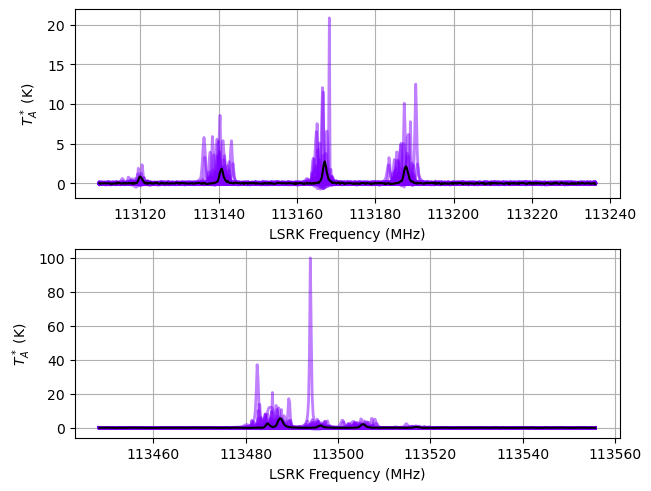

In [5]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = opt.models[1].sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(opt.models[1].data, prior.prior_predictive)

In [6]:
start = time.time()
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.05,
    "learning_rate": 0.01,
}
opt.fit_all(**fit_kwargs)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Null hypothesis BIC = 9.570e+04
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 5400
Interrupted at 5,399 [5%]: Average Loss = 4,718.3


Output()

n_cloud = 1 BIC = -1.656e+03

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 6600
Interrupted at 6,599 [6%]: Average Loss = 3,410


Output()

n_cloud = 2 BIC = -2.515e+03

Approximating n_cloud = 3 posterior...


Output()

Convergence achieved at 10000
Interrupted at 9,999 [9%]: Average Loss = 1,136


Output()

n_cloud = 3 BIC = -3.200e+03

Approximating n_cloud = 4 posterior...


Output()

Convergence achieved at 19300
Interrupted at 19,299 [19%]: Average Loss = -177.7


Output()

n_cloud = 4 BIC = -3.298e+03

Approximating n_cloud = 5 posterior...


Output()

Convergence achieved at 43900
Interrupted at 43,899 [43%]: Average Loss = -1,005.8


Output()

n_cloud = 5 BIC = -3.304e+03

Approximating n_cloud = 6 posterior...


Output()

Convergence achieved at 67300
Interrupted at 67,299 [67%]: Average Loss = -1,209.7


Output()

n_cloud = 6 BIC = -3.186e+03

Runtime: 23.25 minutes


[95704.84851857 -1655.64399933 -2515.18685942 -3199.61513964
 -3297.96860438 -3304.32486781 -3185.82367744]


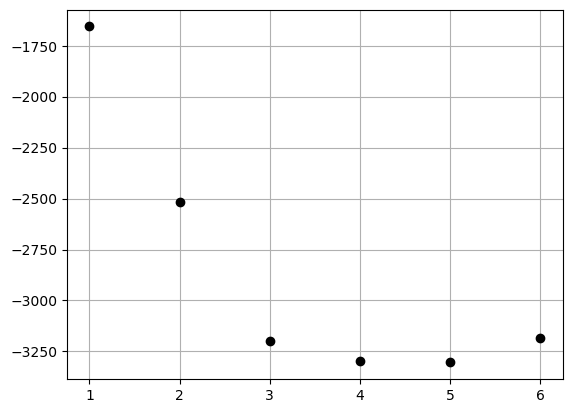

In [7]:
null_bic = opt.models[1].null_bic()
n_clouds = np.arange(max_n_clouds+1)
bics_vi = np.array([null_bic] + [model.bic(chain=0) for model in opt.models.values()])
print(bics_vi)

plt.plot(n_clouds[1:], bics_vi[1:], 'ko')

In [8]:
start = time.time()
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.05,
    "learning_rate": 0.01,
}
sample_kwargs = {
    "chains": 8,
    "cores": 8,
    "n_init": 100_000,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(fit_kwargs=fit_kwargs, sample_kwargs=sample_kwargs, approx=False)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Null hypothesis BIC = 9.570e+04
Sampling n_cloud = 1 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5400
Interrupted at 5,399 [5%]: Average Loss = 4,718.3
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N0_norm, log10_inv_boltz_factor_free]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 128 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = -1.673e+03

Sampling n_cloud = 2 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 6600
Interrupted at 6,599 [6%]: Average Loss = 3,410
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N0_norm, log10_inv_boltz_factor_free]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 285 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = -2.819e+03

Sampling n_cloud = 3 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 10000
Interrupted at 9,999 [9%]: Average Loss = 1,136
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N0_norm, log10_inv_boltz_factor_free]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 1469 seconds.


Adding log-likelihood to trace


Output()

There were 50 divergences in converged chains.
GMM converged to unique solution
7 of 8 chains appear converged.
n_cloud = 3 solution = 0 BIC = -3.252e+03

Sampling n_cloud = 4 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 19300
Interrupted at 19,299 [19%]: Average Loss = -177.7
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N0_norm, log10_inv_boltz_factor_free]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 5490 seconds.


Adding log-likelihood to trace


Output()

There were 20 divergences in converged chains.
GMM converged to unique solution
n_cloud = 4 solution = 0 BIC = -3.340e+03

Sampling n_cloud = 5 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 43900
Interrupted at 43,899 [43%]: Average Loss = -1,005.8
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N0_norm, log10_inv_boltz_factor_free]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 10224 seconds.


Adding log-likelihood to trace


Output()

There were 269 divergences in converged chains.
GMM converged to unique solution
7 of 8 chains appear converged.
n_cloud = 5 solution = 0 BIC = -3.473e+03

Sampling n_cloud = 6 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 67300
Interrupted at 67,299 [67%]: Average Loss = -1,209.7
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N0_norm, log10_inv_boltz_factor_free]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 21613 seconds.


Adding log-likelihood to trace


Output()

There were 388 divergences in converged chains.
GMM found 2 unique solutions
Solution 0: chains [1, 3]
Solution 1: chains [6, 7]
4 of 8 chains appear converged.
n_cloud = 6 solution = 0 BIC = -3.506e+03
n_cloud = 6 solution = 1 BIC = -3.494e+03

Runtime: 691.72 minutes


There is not a unique solution. Must supply solution.
[95704.84851857 -1673.01684728 -2818.9916324  -3251.67608713
 -3339.83570419 -3473.08264969            inf]


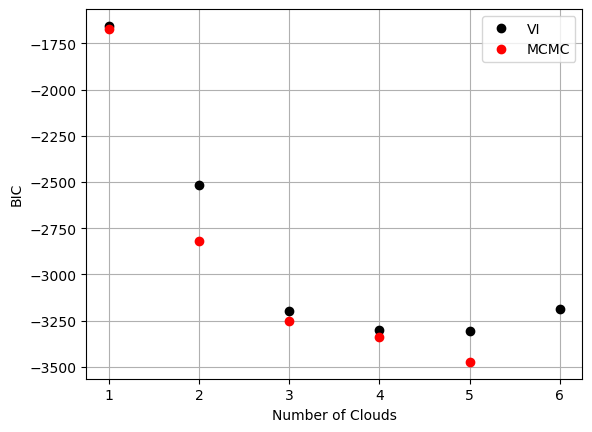

In [9]:
null_bic = opt.models[1].null_bic()
n_clouds = np.arange(max_n_clouds+1)
bics_mcmc = np.array([null_bic] + [model.bic() for model in opt.models.values()])
print(bics_mcmc)

plt.plot(n_clouds[1:], bics_vi[1:], 'ko', label="VI")
plt.plot(n_clouds[1:], bics_mcmc[1:], 'ro', label="MCMC")
plt.xlabel("Number of Clouds")
plt.ylabel("BIC")
_ = plt.legend()

In [33]:
model = opt.models[2]
print(model.n_clouds)
pm.summary(model.trace.solution_0, var_names=model.cloud_deterministics + model.hyper_deterministics)

2


/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
velocity[0],9.170,0.008,9.156,9.185,0.000,0.000,8767.0,5962.0,1.0
velocity[1],8.911,0.023,8.867,8.952,0.000,0.000,5092.0,5154.0,1.0
fwhm_thermal[0],0.236,0.000,0.236,0.236,0.000,0.000,8000.0,8000.0,NaN
fwhm_thermal[1],0.236,0.000,0.236,0.236,0.000,0.000,8000.0,8000.0,NaN
fwhm_nonthermal[0],1.589,0.042,1.512,1.671,0.001,0.001,2673.0,3857.0,1.0
fwhm_nonthermal[1],2.234,0.066,2.109,2.356,0.001,0.001,4900.0,5241.0,1.0
fwhm[0],1.607,0.042,1.531,1.688,0.001,0.001,2673.0,3857.0,1.0
fwhm[1],2.246,0.066,2.122,2.368,0.001,0.001,4900.0,5241.0,1.0
log10_N0[0],14.155,0.022,14.114,14.195,0.000,0.000,2553.0,3549.0,1.0
log10_N0[1],15.011,0.049,14.916,15.100,0.001,0.001,2673.0,4208.0,1.0


Sampling: [12CN-1/2, 12CN-3/2]


Output()

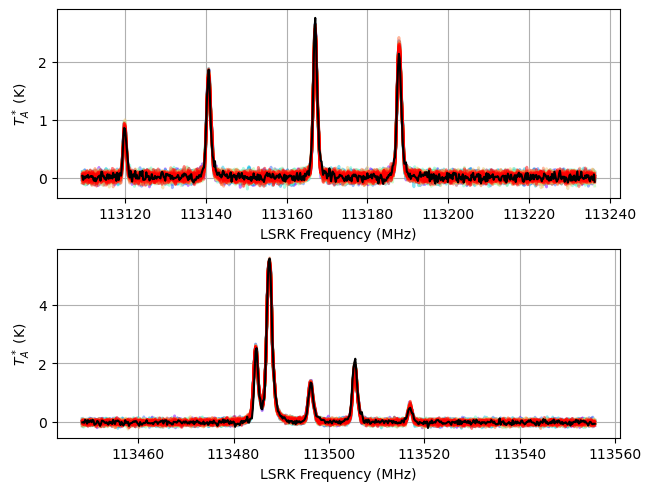

In [34]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## How does total column density depend on number of clouds?

In [26]:
Ntot_clouds = [(10.0**model.trace.solution_0["log10_N"]).sum(dim="cloud") for model in opt.models.values()]

Text(0, 0.5, 'Total Column Density')

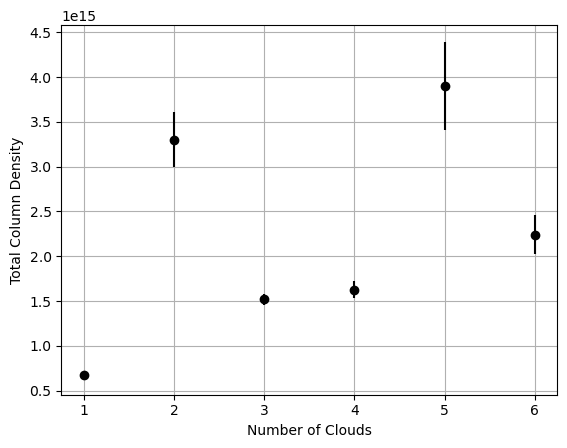

In [30]:
Ntot_cloud_mean = [np.mean(Ntot.data) for Ntot in Ntot_clouds]
Ntot_cloud_std = [np.std(Ntot.data) for Ntot in Ntot_clouds]

plt.errorbar(n_clouds[1:], Ntot_cloud_mean, yerr=Ntot_cloud_std, linestyle="none", marker="o", color="k")
plt.xlabel("Number of Clouds")
plt.ylabel("Total Column Density")

## Assumption about 13CN Excitation Temperature

In [56]:
# Column density weighted mean excitation temperature
model = opt.models[6]

N_12CN_weights = 10.0**model.trace.solution_0["log10_N"]
Tex_12CN = model.trace.solution_0["Tex"]
mean_Tex_12CN = (N_12CN_weights * Tex_12CN).sum(dim="cloud")/N_12CN_weights.sum(dim="cloud")

/tmp/ipykernel_1497/1853051722.py:1: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(mean_Tex_12CN.data).flatten(), bins=100, density=True)
/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/xarray/core/computation.py:818: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/xarray/core/computation.py:818: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


log10 Tex 12CN <xarray.DataArray ()> Size: 8B
array(0.86762017) <xarray.DataArray ()> Size: 8B
array(0.27061549)


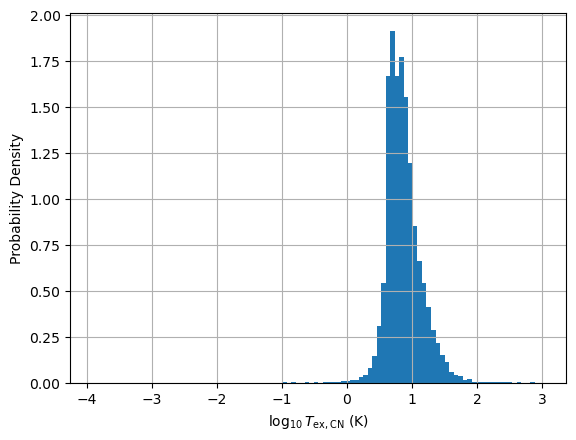

In [57]:
plt.hist(np.log10(mean_Tex_12CN.data).flatten(), bins=100, density=True)
plt.xlabel(r"$\log_{10} T_{\rm ex, CN}$ (K)")
plt.ylabel("Probability Density")

print("log10 Tex 12CN", np.log10(mean_Tex_12CN).mean(), np.log10(mean_Tex_12CN).std())